<a href="https://colab.research.google.com/github/dejunga/ML-Vehicle_Image_Classification/blob/main/Vehicle_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vehicle-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5521913%2F9142550%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240910%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240910T111846Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3181f9a75dd97d91817dc2370d400da1917ff2a6dc83d18c683291cf3d15215173ecf33b34150ce0f40378e372215506e4885e339aba2658cddadf87508849acd718ae4569928ec22a1f72bedbef187be2d4675646e4686b612576b864dbfa8998607787999d745ab7465dcfa117d46c194a2482e23c77d2db02d7cfd1b1eee420d8a5364e1782fefbf4c44411d6f3309b376a7fb535ba405d5b233ba7f5903e63476183f6aa51dd3c55f66096a023e0fa139ef3b3e4b382c5929e1501cd9e7209e4459f56c64bf7c500c19f8709cf43451c6e8da3663223eac2d9301b819e2665f6b9c62ff51fc68ba753059235f999a3defcabf57aa73533452950d7e7c506'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 866783573 bytes downloaded
Downloaded and uncompressed: vehicle-classification
Data source import complete.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [3]:
import shutil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [4]:
main_dir = "/kaggle/input/vehicle-classification/Vehicles"
categories = ["Auto Rickshaws", "Bikes", "Cars", "Motorcycles", "Planes", "Ships", "Trains"]

In [5]:
split_dirs = ["train", "val", "test"]
base_split_dir = "/kaggle/working/vehicles_split"

for split_dir in split_dirs:
    for category in categories:
        os.makedirs(os.path.join(base_split_dir, split_dir, category), exist_ok=True)

In [6]:
for category in categories:
    category_path = os.path.join(main_dir, category)
    images = os.listdir(category_path)
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    def move_images(image_list, destination):
        for image in image_list:
            shutil.copy(os.path.join(category_path, image), os.path.join(base_split_dir, destination, category, image))

    move_images(train_images, "train")
    move_images(val_images, "val")
    move_images(test_images, "test")

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(os.path.join(base_split_dir, "train"), target_size=(150, 150),
                                                    batch_size=32, class_mode='categorical')
val_generator = val_test_datagen.flow_from_directory(os.path.join(base_split_dir, "val"), target_size=(150, 150),
                                                     batch_size=32, class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory(os.path.join(base_split_dir, "test"), target_size=(150, 150),
                                                      batch_size=32, class_mode='categorical')

Found 3911 images belonging to 7 classes.
Found 837 images belonging to 7 classes.
Found 839 images belonging to 7 classes.


In [8]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 60/123 ━━━━━━━━━━━━━━━━━━━━ 31s 495ms/step - accuracy: 0.4681 - loss: 1.9267

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


123/123 ━━━━━━━━━━━━━━━━━━━━ 94s 609ms/step - accuracy: 0.5794 - loss: 1.4508 - val_accuracy: 0.9140 - val_loss: 0.2568
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 116s 497ms/step - accuracy: 0.8297 - loss: 0.4991 - val_accuracy: 0.9020 - val_loss: 0.2482
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 64s 499ms/step - accuracy: 0.8477 - loss: 0.4438 - val_accuracy: 0.9259 - val_loss: 0.2280
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 78s 467ms/step - accuracy: 0.8596 - loss: 0.3997 - val_accuracy: 0.9211 - val_loss: 0.2221
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 463ms/step - accuracy: 0.8488 - loss: 0.4126 - val_accuracy: 0.9128 - val_loss: 0.2451
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 65s 502ms/step - accuracy: 0.8627 - loss: 0.3844 - val_accuracy: 0.9391 - val_loss: 0.1807
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 61s 475ms/step - accuracy: 0.8766 - loss: 0.3242 - val_accuracy: 0.9379 - val_loss: 0.1833
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 60s 463ms/step - accuracy: 0.8831 - loss: 0.3378 - va

In [10]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 0.9368 - loss: 0.1729
Test accuracy: 93.80%


In [11]:
base_model.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history_fine = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 110s 646ms/step - accuracy: 0.9064 - loss: 0.2868 - val_accuracy: 0.9594 - val_loss: 0.1286
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 68s 525ms/step - accuracy: 0.9130 - loss: 0.2251 - val_accuracy: 0.9642 - val_loss: 0.1108
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 83s 543ms/step - accuracy: 0.9375 - loss: 0.1724 - val_accuracy: 0.9665 - val_loss: 0.1046
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 67s 524ms/step - accuracy: 0.9499 - loss: 0.1515 - val_accuracy: 0.9677 - val_loss: 0.1030
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 82s 523ms/step - accuracy: 0.9543 - loss: 0.1301 - val_accuracy: 0.9665 - val_loss: 0.0790
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 87s 568ms/step - accuracy: 0.9638 - loss: 0.1015 - val_accuracy: 0.9761 - val_loss: 0.0741
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 77s 526ms/step - accuracy: 0.9724 - loss: 0.0703 - val_accuracy: 0.9677 - val_loss: 0.1230
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 68s 528ms/step - accuracy: 0.9723 - loss: 

In [13]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc * 100:.2f}%")

27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step - accuracy: 0.9789 - loss: 0.0759
Test accuracy: 97.62%


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be exe

epoch,train_loss,valid_loss,accuracy,time
0,0.504549,0.249689,0.923008,01:23


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.234462,0.131982,0.957028,01:28
1,0.279956,0.110333,0.965085,01:21
2,0.193801,0.097685,0.973142,01:22
3,0.154115,0.129434,0.962399,01:27
4,0.095690,0.092894,0.968666,01:22
5,0.091281,0.111821,0.970457,01:22
6,0.065867,0.098747,0.974038,01:26
7,0.025271,0.076068,0.980304,01:25
8,0.025715,0.081586,0.977619,01:24
9,0.020569,0.077141,0.978514,01:29


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes sh

Epoch 1 - train_loss: 0.2345, valid_loss: 0.1320, accuracy: 0.9570
Epoch 2 - train_loss: 0.2800, valid_loss: 0.1103, accuracy: 0.9651
Epoch 3 - train_loss: 0.1938, valid_loss: 0.0977, accuracy: 0.9731
Epoch 4 - train_loss: 0.1541, valid_loss: 0.1294, accuracy: 0.9624
Epoch 5 - train_loss: 0.0957, valid_loss: 0.0929, accuracy: 0.9687
Epoch 6 - train_loss: 0.0913, valid_loss: 0.1118, accuracy: 0.9705
Epoch 7 - train_loss: 0.0659, valid_loss: 0.0987, accuracy: 0.9740
Epoch 8 - train_loss: 0.0253, valid_loss: 0.0761, accuracy: 0.9803
Epoch 9 - train_loss: 0.0257, valid_loss: 0.0816, accuracy: 0.9776
Epoch 10 - train_loss: 0.0206, valid_loss: 0.0771, accuracy: 0.9785


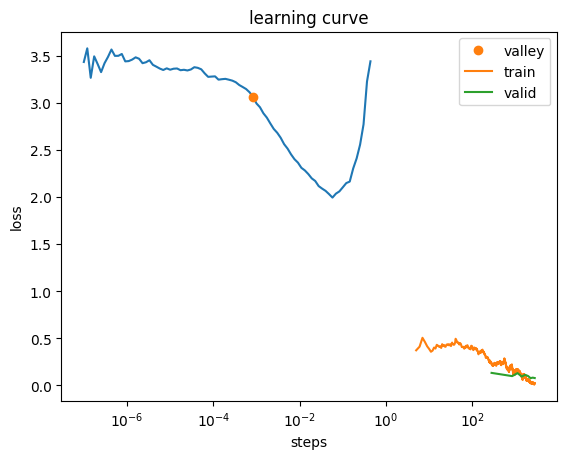

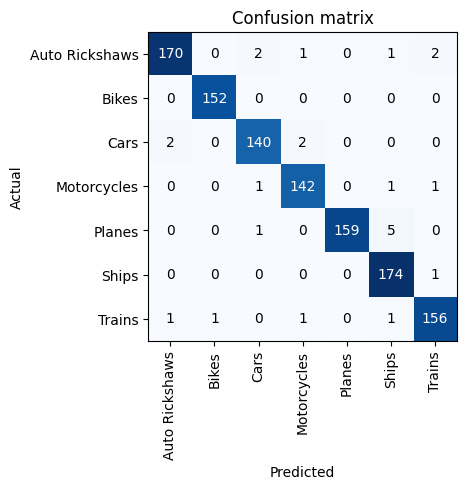

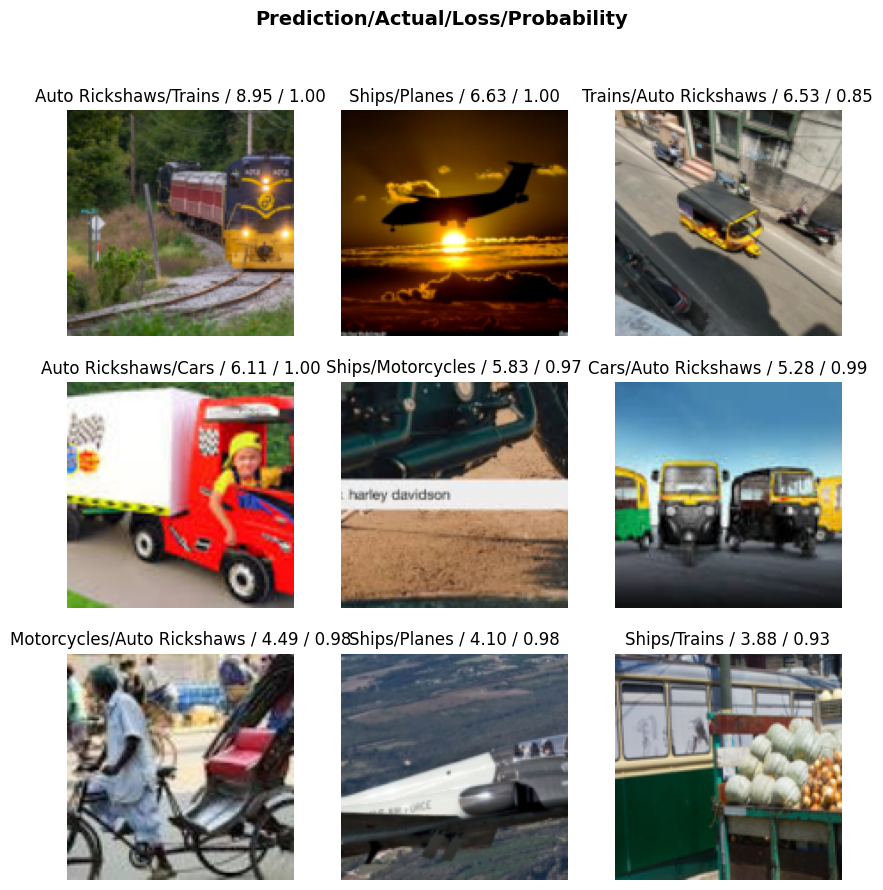

In [14]:
import gc
import torch
from fastai.vision.all import *
from pathlib import Path

# Clear GPU memory if needed
torch.cuda.empty_cache()
gc.collect()

# Set your dataset path
main_dir = Path("/kaggle/input/vehicle-classification/Vehicles")

# Load dataset with smaller image size and reduced batch size
# Resize to 128x128 and use a batch size of 16 to prevent memory issues
dls = ImageDataLoaders.from_folder(main_dir, valid_pct=0.2, item_tfms=Resize(128), batch_size=16)

# Use ResNet18 (lightweight model) with mixed precision training to reduce memory usage
learn = vision_learner(dls, resnet18, metrics=[accuracy], path='/kaggle/working/').to_fp16()

# Find the best learning rate (optional step, but recommended)
learn.lr_find()

# Fine-tune the model for 20 epochs
learn.fine_tune(10)

# Plot loss over time
learn.recorder.plot_loss()

# Additional metrics (train_loss, valid_loss, accuracy) for each epoch
for epoch, (train_loss, valid_loss, accuracy) in enumerate(learn.recorder.values):
    print(f"Epoch {epoch+1} - train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, accuracy: {accuracy:.4f}")

# Show confusion matrix to see where the model is making mistakes
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Plot the top losses to understand which images contributed most to the errors
interp.plot_top_losses(9, figsize=(10,10))

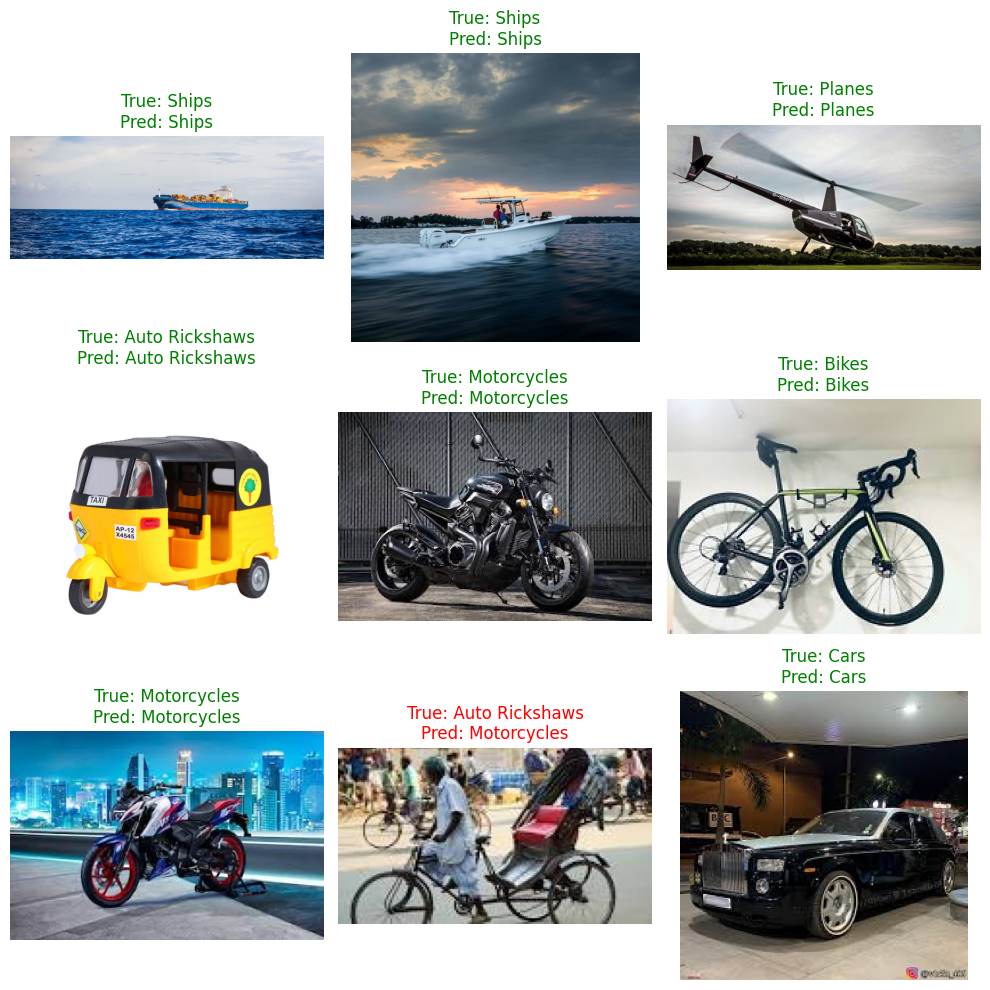

In [15]:
import matplotlib.pyplot as plt
import random
from fastai.vision.all import *

# Select random test images from the validation set
# Access the validation DataLoader (dls.valid)
n_images = 9  # Number of images to display
valid_dl = learn.dls.valid

# Randomly choose 9 validation samples
indices = random.sample(range(len(valid_dl.dataset.items)), n_images)

# Plot predictions for each image
plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    # Get the image and true label from the validation set
    img, true_label = valid_dl.dataset[idx]

    # Make a prediction using the trained model
    pred_label, _, probs = learn.predict(img)

    # Convert image (PIL) to tensor and then to numpy array for display
    img_tensor = PILImage.create(img)
    img_np = np.array(img_tensor)  # Convert PIL image to numpy array

    # Plot the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img_np)
    plt.axis('off')

    # Set the title to show true and predicted labels, colored by correctness
    true_label_str = valid_dl.vocab[true_label]
    pred_label_str = str(pred_label)
    color = 'green' if true_label_str == pred_label_str else 'red'
    plt.title(f"True: {true_label_str}\nPred: {pred_label_str}", color=color)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


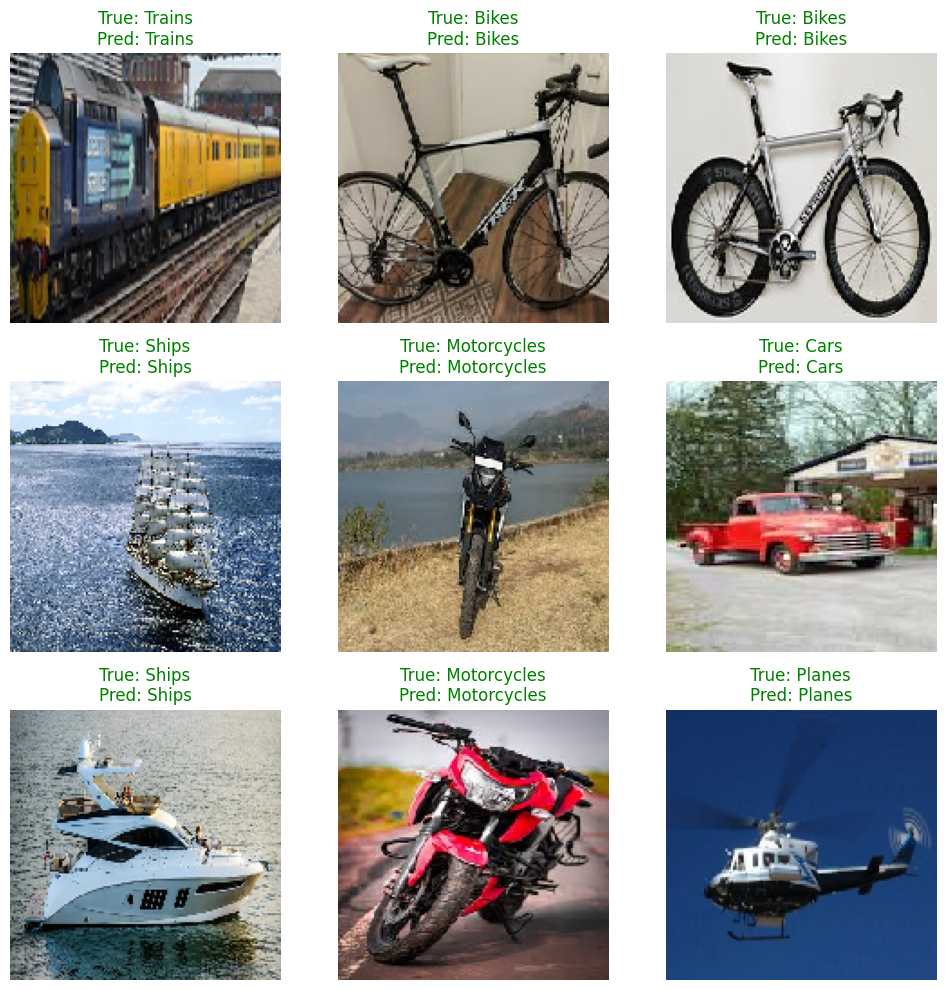

In [16]:
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img


test_images, test_labels = next(test_generator)
indices = random.sample(range(len(test_images)), 9)

predictions = model.predict(test_images[indices])
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels[indices], axis=1)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_images[idx])
    plt.axis('off')

    true_label = categories[true_labels[i]]
    predicted_label = categories[predicted_labels[i]]
    color = 'green' if true_label == predicted_label else 'red'

    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)

plt.tight_layout()
plt.show()